In [1]:
!git clone https://github.com/cknd/pyESN.git

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106 (from 1)
Receiving objects: 100% (106/106), 1.17 MiB | 4.70 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
import sys
sys.path.append('/content/pyESN')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving continuous_factory_process.csv to continuous_factory_process.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyESN import ESN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, precision_recall_curve, accuracy_score

In [5]:
data = pd.read_csv('continuous_factory_process.csv')

In [6]:
relevant_columns = [
    'Machine1.RawMaterialFeederParameter.U.Actual',
    'Machine1.Zone1Temperature.C.Actual',
    'Machine1.Zone2Temperature.C.Actual',
    'Stage2.Output.Measurement1.U.Actual',
    'Stage2.Output.Measurement1.U.Setpoint',
    'Stage2.Output.Measurement2.U.Actual',
    'Stage2.Output.Measurement2.U.Setpoint'
]
selected_data = data[relevant_columns]

# Sensor columns (input features)
sensor_columns = [
    'Machine1.RawMaterialFeederParameter.U.Actual',
    'Machine1.Zone1Temperature.C.Actual',
    'Machine1.Zone2Temperature.C.Actual',
    'Stage2.Output.Measurement1.U.Actual',
    'Stage2.Output.Measurement2.U.Actual'
]

In [7]:
normalized_data = (selected_data[sensor_columns] - selected_data[sensor_columns].min()) / (selected_data[sensor_columns].max() - selected_data[sensor_columns].min())

In [8]:
train_input, test_input, train_output, test_output = train_test_split(
    normalized_data.values[:-1], normalized_data.values[1:], test_size=0.2, random_state=42
)

In [9]:
esn = ESN(n_inputs=train_input.shape[1],
          n_outputs=train_output.shape[1],
          n_reservoir=1000,        # Increased reservoir size for better capacity
          sparsity=0.05,           # Reduced sparsity for more connections
          spectral_radius=1.2,     # Increased spectral radius to improve long-term memory
          random_state=42)

In [10]:
esn.fit(train_input, train_output)

array([[ 0.90372178,  0.1601417 ,  0.58211631,  0.55349734,  0.71515413],
       [ 0.92981107,  0.33185812,  0.51061659,  0.53544637,  0.68876649],
       [ 0.90137034,  0.1631695 ,  0.38079259,  0.51447553,  0.64763875],
       ...,
       [ 0.39669245,  0.1591603 ,  0.29100234,  0.56259706,  0.6385875 ],
       [ 0.94800877,  0.34241866, -0.01901639,  0.44966974,  0.63370198],
       [ 0.94020981,  0.1641141 ,  0.848975  ,  0.526228  ,  0.68088403]])

In [11]:
predicted_train_output = esn.predict(train_input)
predicted_test_output = esn.predict(test_input)

In [12]:
predicted_train_flat = predicted_train_output.flatten()
train_output_flat = train_output.flatten()

In [13]:
predicted_test_flat = predicted_test_output.flatten()
test_output_flat = test_output.flatten()

In [14]:
smoothed_train_actual = pd.Series(train_output_flat).ewm(span=10).mean().values
smoothed_train_pred = pd.Series(predicted_train_flat).ewm(span=10).mean().values

smoothed_test_actual = pd.Series(test_output_flat).ewm(span=10).mean().values
smoothed_test_pred = pd.Series(predicted_test_flat).ewm(span=10).mean().values

In [15]:
error_margin = np.std(smoothed_train_actual - smoothed_train_pred)
threshold = 2 * error_margin

In [16]:
anomalies_train = np.where(np.abs(smoothed_train_pred - smoothed_train_actual) > threshold)[0]
anomalies_test = np.where(np.abs(smoothed_test_pred - smoothed_test_actual) > threshold)[0]

In [17]:
mse_train = mean_squared_error(train_output_flat, predicted_train_flat)
mae_train = mean_absolute_error(train_output_flat, predicted_train_flat)
r2_train = r2_score(train_output_flat, predicted_train_flat)

mse_test = mean_squared_error(test_output_flat, predicted_test_flat)
mae_test = mean_absolute_error(test_output_flat, predicted_test_flat)
r2_test = r2_score(test_output_flat, predicted_test_flat)

print(f"Train Set Mean Squared Error (MSE): {mse_train}")
print(f"Train Set Mean Absolute Error (MAE): {mae_train}")
print(f"Train Set R-squared: {r2_train}")
print(f"Test Set Mean Squared Error (MSE): {mse_test}")
print(f"Test Set Mean Absolute Error (MAE): {mae_test}")
print(f"Test Set R-squared: {r2_test}")

Train Set Mean Squared Error (MSE): 0.002390253566032023
Train Set Mean Absolute Error (MAE): 0.019127220298562727
Train Set R-squared: 0.9712138179413488
Test Set Mean Squared Error (MSE): 0.0031145029096800204
Test Set Mean Absolute Error (MAE): 0.0220183827392541
Test Set R-squared: 0.9624046672311208


Text(0.5, 1.0, 'True vs Predicted Train Data with Detected Anomalies')

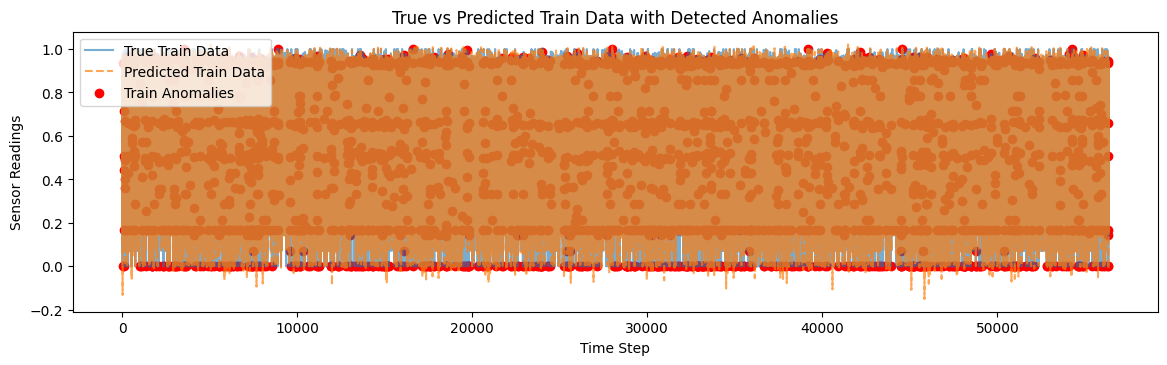

In [18]:
plt.figure(figsize=(14, 8))

# Train Data - True vs Predicted with anomalies
plt.subplot(2, 1, 1)
plt.plot(range(len(train_output_flat)), train_output_flat, label="True Train Data", alpha=0.6)
plt.plot(range(len(predicted_train_flat)), predicted_train_flat, label="Predicted Train Data", linestyle="--", alpha=0.7)
plt.scatter(anomalies_train, train_output_flat[anomalies_train], color='red', label="Train Anomalies")
plt.xlabel("Time Step")
plt.ylabel("Sensor Readings")
plt.legend(loc="upper left")
plt.title("True vs Predicted Train Data with Detected Anomalies")

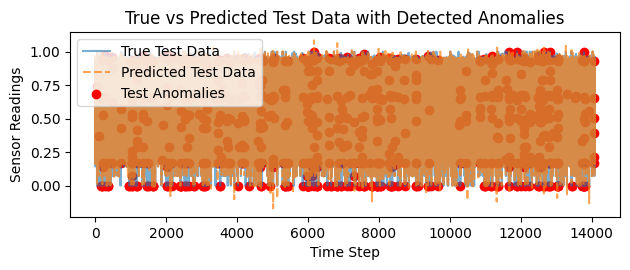

In [19]:
plt.subplot(2, 1, 2)
plt.plot(range(len(test_output_flat)), test_output_flat, label="True Test Data", alpha=0.6)
plt.plot(range(len(predicted_test_flat)), predicted_test_flat, label="Predicted Test Data", linestyle="--", alpha=0.7)
plt.scatter(anomalies_test, test_output_flat[anomalies_test], color='red', label="Test Anomalies")
plt.xlabel("Time Step")
plt.ylabel("Sensor Readings")
plt.legend(loc="upper left")
plt.title("True vs Predicted Test Data with Detected Anomalies")

plt.tight_layout()
plt.show()

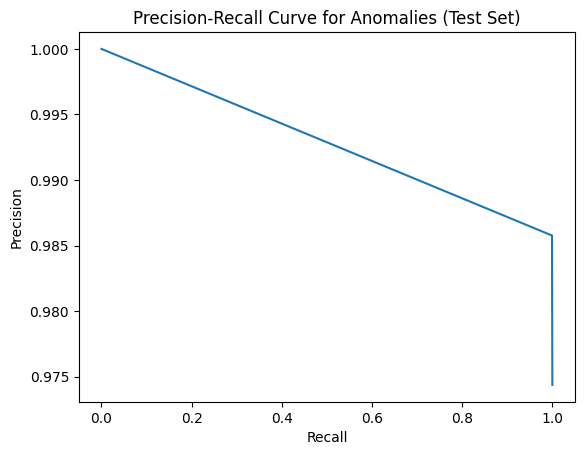

In [22]:
precision, recall, _ = precision_recall_curve(test_output_flat > threshold, predicted_test_flat > threshold)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Anomalies (Test Set)')
plt.show()

In [23]:
f1 = f1_score(test_output_flat > threshold, predicted_test_flat > threshold)
print(f"F1 Score (Test Set): {f1}")

F1 Score (Test Set): 0.9924398625429554


In [31]:
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
train_input, val_input, train_output, val_output = train_test_split(
    normalized_data.values[:-1],
    normalized_data.values[1:],
    test_size=0.2,
    random_state=42
)


Epoch 1/100, Training Loss: 0.0024, Training Accuracy: 0.9532, Validation Loss: 0.0031, Validation Accuracy: 0.9500
Epoch 2/100, Training Loss: 0.0024, Training Accuracy: 0.9537, Validation Loss: 0.0031, Validation Accuracy: 0.9503
Epoch 3/100, Training Loss: 0.0024, Training Accuracy: 0.9535, Validation Loss: 0.0032, Validation Accuracy: 0.9500
Epoch 4/100, Training Loss: 0.0024, Training Accuracy: 0.9539, Validation Loss: 0.0032, Validation Accuracy: 0.9496
Epoch 5/100, Training Loss: 0.0024, Training Accuracy: 0.9535, Validation Loss: 0.0032, Validation Accuracy: 0.9503
Epoch 6/100, Training Loss: 0.0024, Training Accuracy: 0.9540, Validation Loss: 0.0031, Validation Accuracy: 0.9510
Epoch 7/100, Training Loss: 0.0024, Training Accuracy: 0.9539, Validation Loss: 0.0032, Validation Accuracy: 0.9500
Epoch 8/100, Training Loss: 0.0024, Training Accuracy: 0.9539, Validation Loss: 0.0032, Validation Accuracy: 0.9507
Epoch 9/100, Training Loss: 0.0024, Training Accuracy: 0.9540, Validatio

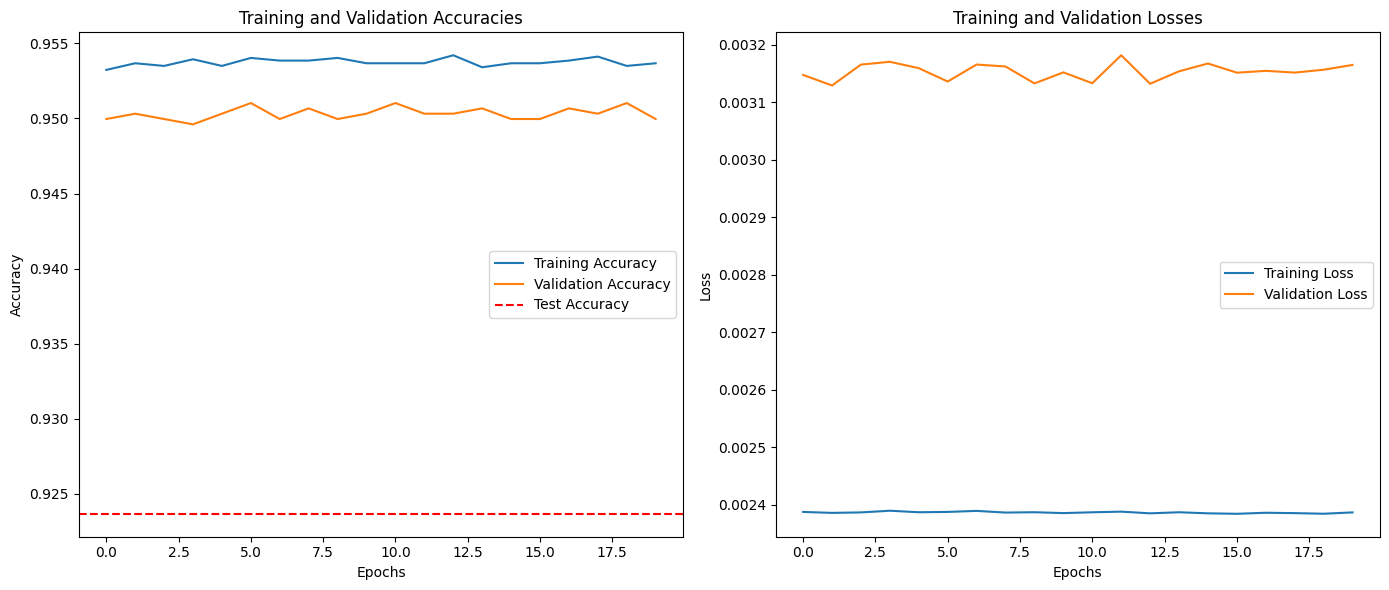

In [34]:
from sklearn.metrics import accuracy_score

# Lists to store losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Number of epochs
num_epochs = 100  # Set your desired number of epochs

for epoch in range(20):
    # Fit the ESN model on training data
    esn.fit(train_input, train_output)

    # Make predictions for training set
    predicted_train_output = esn.predict(train_input)
    train_loss = mean_squared_error(train_output, predicted_train_output)
    train_accuracy = accuracy_score(train_output > threshold, predicted_train_output > threshold)  # Adjust threshold as needed

    # Make predictions for validation set
    predicted_val_output = esn.predict(val_input)
    val_loss = mean_squared_error(val_output, predicted_val_output)
    val_accuracy = accuracy_score(val_output > threshold, predicted_val_output > threshold)  # Adjust threshold as needed

    # Store losses and accuracies
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

    # Print losses and accuracies for monitoring
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# After training, calculate test accuracy
predicted_test_output = esn.predict(test_input)  # Make sure you have test_input prepared
test_accuracy = accuracy_score(test_output > threshold, predicted_test_output > threshold)  # Adjust threshold as needed

print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualization of accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Line for test accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

# Plot losses (optional)
plt.subplot(1, 2, 2)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.tight_layout()
plt.show()


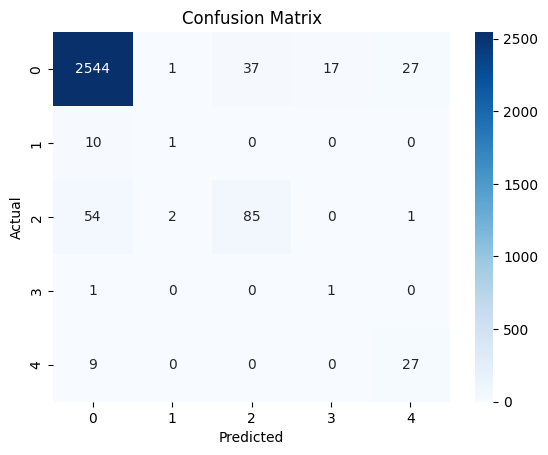

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Convert multilabel-indicator to multiclass
test_output_classes = np.argmax(test_output, axis=1)
predicted_test_output_classes = np.argmax(predicted_test_output, axis=1)

cm = confusion_matrix(test_output_classes, predicted_test_output_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

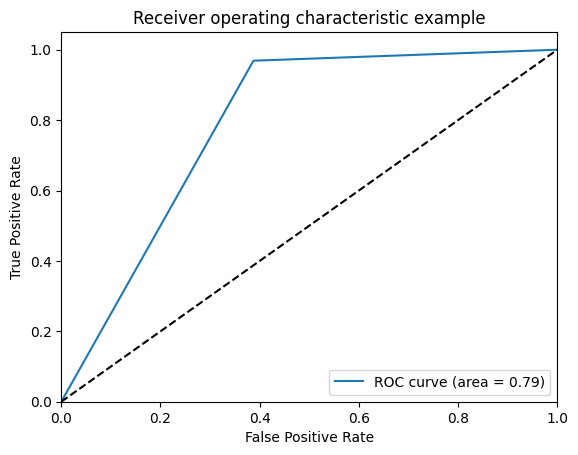

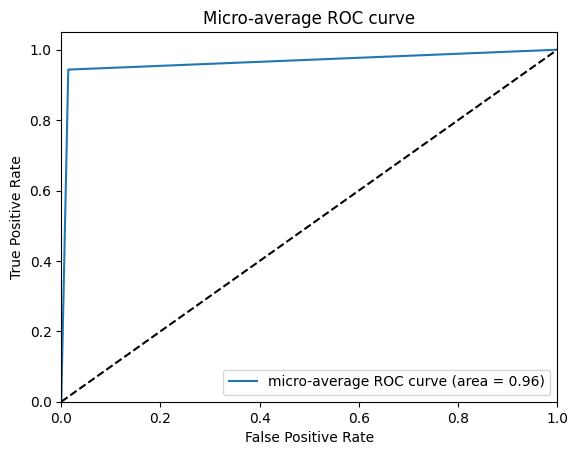

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

# Convert multilabel-indicator to multiclass
test_output_classes = np.argmax(test_output, axis=1)
predicted_test_output_classes = np.argmax(predicted_test_output, axis=1)

# Binarize the output
y_test_binarized = label_binarize(test_output_classes, classes=np.unique(test_output_classes))
y_pred_binarized = label_binarize(predicted_test_output_classes, classes=np.unique(test_output_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = roc_auc_score(y_test_binarized, y_pred_binarized, average="micro")

# Plot ROC curve for a specific class (e.g., class 0)
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

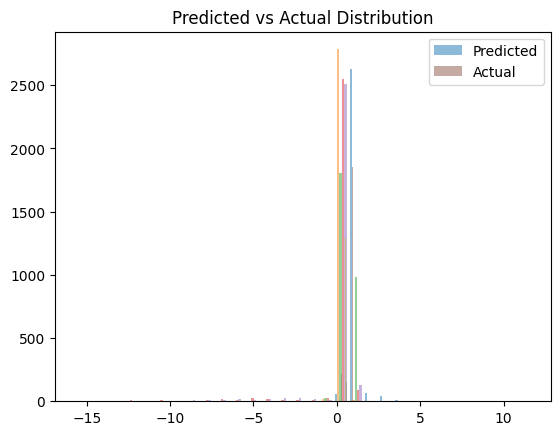

In [40]:
plt.hist(predicted_test_output, bins=30, alpha=0.5, label='Predicted')
plt.hist(test_output, bins=30, alpha=0.5, label='Actual')
plt.legend()
plt.title('Predicted vs Actual Distribution')
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


0.5811027389068293


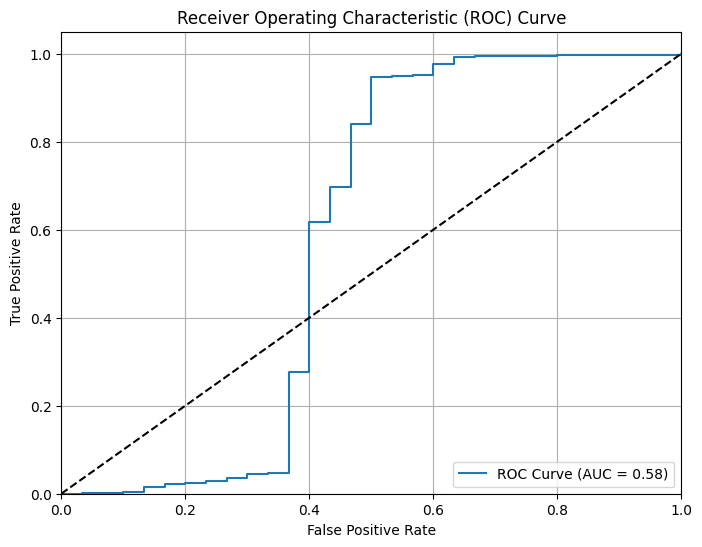

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming predicted_test_output contains your model's predictions
# and test_output contains the true labels

# Convert your output to binary (1 for positive class, 0 for negative class)
# Ensure you are working with a single label (e.g., the first label)
# Adjust threshold as needed - the original value of 0.036 was too low
threshold = 0.5
binary_true_labels = (test_output[:, 0] > threshold).astype(int)

# Select the corresponding predictions for the chosen label
predicted_probabilities = predicted_test_output[:, 0]

# Calculate false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(binary_true_labels, predicted_probabilities)

# Calculate AUC
auc_score = roc_auc_score(binary_true_labels, predicted_probabilities)

print(auc_score)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()